# Проект №3. О вкусной и здоровой пище 

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np 
import re
import json
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import unicodedata #для транслитерации не ASCII
import unidecode #для транслитерации не ASCII 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import itertools
%matplotlib inline

In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
# Для воспроизводимости результатов зададим:
# - общий параметр для генерации случайных чисел
RANDOM_SEED = 17
# - общую текущую дату
# CURRENT_DATE = pd.to_datetime('22/02/2020')
CURRENT_DATE = pd.to_datetime('13/02/2021')


# DATA

In [4]:
DATA_DIR = 'sf-dst-restaurant-rating/'
df_in = pd.read_csv(DATA_DIR+'main_task.csv')
# Путь к датасету для которого требуется предсказать рейтинг
df_kagle = pd.read_csv(DATA_DIR+'kaggle_task.csv')
#Путь к 'submission.csv' - ответы
submission_path = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [5]:
# датасет стран
DS_IMPORT_SC_DIR = 'cities-and-countries/'
# Путь к датасету стран - отсюда берем столицы
df_county = pd.read_csv(DS_IMPORT_SC_DIR+'country-list.csv')
#датасет по городам и странам
df_urb_xls = pd.read_excel(DS_IMPORT_SC_DIR+'global-city-population-estimates.xls', index_col=None, header=0, sheet_name = 'CITIES-OVER-300K')

# Путь к датасету, содержащему слова с позитивной и негативной окраской
df_pos_words = pd.read_csv('opinion-lexicon-english/positive-words.txt',skiprows=34, names=['word'])
pos_words_list = df_pos_words['word'].to_list()  

In [6]:
# Путь к датасету, содержащему слова с негативной окраской
df_neg_words = pd.read_csv('opinion-lexicon-english/neg_words.txt',encoding='windows-1251', names=['word'])
neg_words_list = df_neg_words['word'].to_list()

# FUNC

In [7]:
 def get_season(date):
    '''
    Время года из даты
    '''
    if (pd.isna(date)):
        return "OTHER"
    month = date.month
    if (month > 11 or month <= 3):
       return "WINTER"
    elif (month == 4 or month == 5):
       return "SPRING"
    elif (month >=6 and month <= 9):
       return "SUMMER"
    else:
       return "FALL"

In [8]:
def round_of_rating(number):
    """
    Округляем до 0.5
    """
    return np.round(number * 2) / 2

In [9]:
def get_Weighed_Rank_RK(row):
    '''
    Вычисляем относительную позицию ресторана среди всех ресторанов города
    '''
    Weighed_Rank = row['Ranking'] / row['Restaurants Count']

    return Weighed_Rank

In [10]:
def get_Weighed_Rank(row):
    i=0
    city_min = CityMinMax[CityMinMax['City'] == row.City ]['min'].iloc[0]
    city_max = CityMinMax[CityMinMax['City'] == row.City ]['max'].iloc[0]
    Weighed_Rank = round(1-(row['Ranking'] - city_min)/(city_max - city_min),3)
    #print('<---',Weighed_Rank,'--->')
    return Weighed_Rank

In [11]:
def rev_time_delta(reviews):
    '''
    Вычисляем время между review в днях
    '''
    if (pd.notna(reviews)):
        reviews_dt_list = get_reviews(reviews)['reviews_dt']
        if reviews_dt_list:
            return (max(reviews_dt_list) - min(reviews_dt_list)).days
        else:
            return dt.timedelta(days=3650).days
    else:
        return dt.timedelta(days=3650).days

In [12]:
def get_reviews(rev):
    '''
    Получаем review в виде:
    review['reviews_txt'][1] - list of reviews
    review['reviews_dt'][1] - list of reviews dates
    '''
    if  not pd.isna(rev): 
        rev = str(rev).replace("'",'"')
        rev = rev.replace('], [', '], "reviews_dt": [')
        rev = '{ "reviews_txt":' + rev + '}'
        rev = rev.replace('[[','[').replace(']]',']')
        d = json.loads(rev)

        d['reviews_dt'] = [dt.datetime.strptime(date, '%m/%d/%Y').date() if len(date.split('/')[2])==4 else dt.datetime.strptime(date, '%m/%d/%y').date() for date in d['reviews_dt']]
        return d
    else:
        return {}

In [13]:
def get_cuisines(cuisines):
    '''
    Получаем список кухонь в виде:
    cuisines[0] - list of cusines
    если был NaN, то возвращается 'Regionl Cusine' -как самая популярная в регионе/городе/стране
    '''
    if cuisines == 'NaN': return ['Regionl Cusine']#['Vegetarian Friendly'] # 'Vegetarian Friendly' - самая популярная
    if  cuisines:
        cuisines = str(cuisines).replace("'",'"')
        return json.loads(cuisines)
    else:
        return ['Regionl Cusine'] #return ['Vegetarian Friendly']

In [14]:
# список всех кухонь по порядку
allCusines = []
def cuisine_styles_count(row):
    '''
    Получаем количество кухонь
    '''
    global allCusines
    cusines = get_cuisines(row['Cuisine Style'])
    
    if row['Cuisine Style'] != 'NaN':    
        cusines = get_cuisines(row['Cuisine Style'])
        allCusines.extend(cusines)
        cuisines_count =len(cusines)
    else:
        cuisines_count = 1

    return cuisines_count

In [15]:
def cleanup_string(str_in):
    '''
    "Чистим" текст в review для последующй десериализации
    Пока текст в анализе не используется, не успел... 
    '''
    try:      
        
        #middle

        str = str_in.replace("', \"","⅞").replace("', '","⅞").replace("\", '","⅞").replace("\", \"","⅞")# ", 
        str = str.replace("\", \"\"","⅞").replace("\"\", '","⅞").replace("\", \'","⅞").replace("\"\", \'","⅞")
        str = str.replace("\', \'","⅞")
        #middle
        #left
        str = str.replace("[['","≤").replace("['","⅛")
        #left
        #right
        str = str.replace("']]","≥").replace("']","⅝")
        #right
        #cleanups
        str = str.replace('\'', ' ').replace('\"', ' ').replace('\'', ' ').replace('"', ' ')     
        str = str.replace("\\", " ").replace("[[`", "≤").replace('\'"', '\'').replace('\'\"', '\'')
        str = str.replace('"\'', '\'').replace('\"\'', '\'').replace("[''" ,"≤").replace("[\'\'" ,"≤")
        str = str.replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('"', ' ')
        #cleanups
        #middle
        str = str.replace("⅞", "', '")
        #middle
        #left
        str = str.replace("≤", "[['").replace("⅛", "['").replace('[[ ', '[[ \'')
        #left
        #right
        str = str.replace("≥" ,"']]").replace("⅝", "']").replace(' ]', ' \']')
        str = str.replace(', nan]', '\', \'nan\']').replace('[nan, ', '[\'nan\', \'')
        #right
    except Exception:
        print('<----',str_in,'---->')
    return str

In [16]:
def get_city_population_and_country():
    '''
    Получаем популяцию по городам, а так же ISO код страны по городу (из внешних источников)
    '''
    population_city_dict = {}
    country_city_dict = {}
    cities = df['City'].unique()
    # Чистим названия городов от Unicode символов - транслитерацией
    df_urb_xls['Urban Agglomeration TL'] = df_urb_xls['Urban Agglomeration'].apply(lambda s: ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')) )
    df_urb_xls['Urban Agglomeration TL'] =  df_urb_xls['Urban Agglomeration'].apply(lambda x: unidecode.unidecode(x))

    for city in cities:
        vals = df_urb_xls[df_urb_xls['Urban Agglomeration TL'].str.contains(city)]['2015'].max()/1000
        vals = 0.3 if pd.isna(vals) else vals # т.к. в датасете города от 300тыс
        population_city_dict[city] = vals
        country = df_urb_xls[df_urb_xls['Urban Agglomeration TL'].str.contains(city)]['Country Code']
        country = -1 if country.shape[0] < 1 else country.values[0]
        country_city_dict[city] = country

    population_city_dict['Luxembourg'] = 0.613894 
    population_city_dict['Brussels'] = 2.115468 
    population_city_dict['Geneva'] = 0.686562 
    population_city_dict['Oporto'] = 0.214349 
    population_city_dict['Ljubljana'] = 0.279631



    country_city_dict['Luxembourg'] = 442 
    country_city_dict['Brussels'] = 56 
    country_city_dict['Geneva'] = 756 
    country_city_dict['Oporto'] = 620 
    country_city_dict['Ljubljana'] = 705
    
    #Видимо, эти данные корректнее???
    population_city_dict = {    'London': 8.173900,
    'Paris': 2.240621,
    'Madrid': 3.155360,
    'Barcelona': 1.593075,
    'Berlin': 3.326002,
    'Milan': 1.331586,
    'Rome': 2.870493,
    'Prague': 1.272690,
    'Lisbon': .547733,
    'Vienna': 1.765649,
    'Amsterdam': .825080,
    'Brussels': .144784,
    'Hamburg': 1.718187,
    'Munich': 1.364920,
    'Lyon': .496343,
    'Stockholm': 1.981263,
    'Budapest': 1.744665,
    'Warsaw': 1.720398,
    'Dublin': .506211 ,
    'Copenhagen': 1.246611,
    'Athens': 3.168846,
    'Edinburgh': .476100,
    'Zurich': .402275,
    'Oporto': .221800,
    'Geneva': .196150,
    'Krakow': .756183,
    'Oslo': .673469,
    'Helsinki': .574579,
    'Bratislava': .413192,
    'Luxembourg': .576249,
    'Ljubljana': .277554
    }
    return population_city_dict, country_city_dict

In [17]:
def get_capital_city_dict():
    '''
    Возвращаем словарь город == столица или нет
    '''
    capital_city_dict = {}
    cities =df['City'].unique()
    df_county['capital TL'] = df_county['capital'].apply(lambda s: ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')) )
    df_county['capital TL'] =  df_county['capital'].apply(lambda x: unidecode.unidecode(x))
    for city in cities:
        vals = df_county[df_county['capital TL'].str.contains(city)]['country'].shape[0]   
        vals = 0 if pd.isna(vals) or vals==0 else 1 
        capital_city_dict[city] = vals
    capital_city_dict['Barcelona'] = 0 # Страна Басков != Испания, дадим Барселоне статус мтолицы, но оставим в Испании ! 0 и не надо врать :)
    capital_city_dict['Zurich'] = 1 
    capital_city_dict['Geneva'] = 1 
    capital_city_dict['Oporto'] = 1 
    return capital_city_dict

In [18]:
def is_cuisine_top_N(cs):
    '''
    Возвращаем список кухонь, входящих в основной список кухонь,для остальных Other
    '''
    c = get_cuisines(cs)
    c = set(c)

    shared_cousines=()
    shared_cousines=c.intersection(topNcusines)

    if len(shared_cousines) != len(c):
        shared_cousines = list(shared_cousines)
        shared_cousines.extend(['Other'])

    return list(shared_cousines)

In [19]:
def createWordList(line):
    wordList2 =[]
    wordList1 = line.split()
    for word in wordList1:
        cleanWord = ""
        for char in word:
            if char in '!,.?":;0123456789':
                char = ""
            cleanWord += char
        wordList2.append(cleanWord.lower())
    return wordList2

In [20]:
def count_positive_words_proportion(reviews):
    '''
    Количество позитивных слов в приведенных отзывах
    '''
    pos_words_count = 0
    txts=get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)
    #print(type(txt))
    words = createWordList(txt)
    
    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    pos_words_in_review=set(words).intersection(pos_words_list)
    for word in words:
        if word in pos_words_list:
            #print(word)
            pos_words_count +=1  
    return np.round(pos_words_count/words_count,2)

In [21]:
def count_negative_words_proportion(reviews):
    '''
    Количество позитивных слов в приведенных отзывах
    '''
    neg_words_count = 0
    txts=get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)
    #print(type(txt))
    words = createWordList(txt)
    
    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    neg_words_in_review=set(words).intersection(neg_words_list)
    for word in words:
        if word in neg_words_list:
            #print(word)
            neg_words_count +=1  
    return np.round(neg_words_count/words_count,2)

In [22]:
def list_positive_words(reviews): 
    '''
    Список уникальных позитивных слов в приведенных отзывах
    '''
    txts=get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)
    #print(type(txt))
    words = createWordList(txt)
    
    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    pos_words_in_review=set(words).intersection(pos_words_list)
    #print(len(pos_words_in_review))
    if (len(pos_words_in_review) == 0):
        return np.NAN
    else:
        return list(pos_words_in_review)

---  

# WORK

In [23]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [24]:
df_in.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [25]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет

df_kagle['ForTrain'] = False # помечаем где у нас тест
df_kagle['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df_in['ForTrain'] = True # помечаем где у нас трейн
df_in = df_in.append(df_kagle, sort=False).reset_index(drop=True)# объединяем

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [26]:
# Выбираем нужные для последующего анализа столбцы
df = df_in[['Ranking', 'Rating', 'Number of Reviews', 'City', 'Price Range', 'Cuisine Style', 'Reviews', 'Restaurant_id', 'ID_TA', 'ForTrain' ]].copy()

Как видим, большинство признаков требует очистки и предварительной обработки.

* ## 1. Обработка NAN и Обработка признаков
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

**Посмотрим на признаки и к-во пропусков (NaN)**

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            50000 non-null  float64
 1   Rating             50000 non-null  float64
 2   Number of Reviews  46800 non-null  float64
 3   City               50000 non-null  object 
 4   Price Range        32639 non-null  object 
 5   Cuisine Style      38410 non-null  object 
 6   Reviews            49998 non-null  object 
 7   Restaurant_id      50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   ForTrain           50000 non-null  bool   
dtypes: bool(1), float64(3), object(6)
memory usage: 3.5+ MB


**Посмотрим на признаки и к-во уникальных значений**

In [28]:
df.nunique(dropna=False)

Ranking              12975
Rating                  10
Number of Reviews     1574
City                    31
Price Range              4
Cuisine Style        10732
Reviews              41858
Restaurant_id        13094
ID_TA                49963
ForTrain                 2
dtype: int64

**Посмотрим на гистограммы числовых признаков**

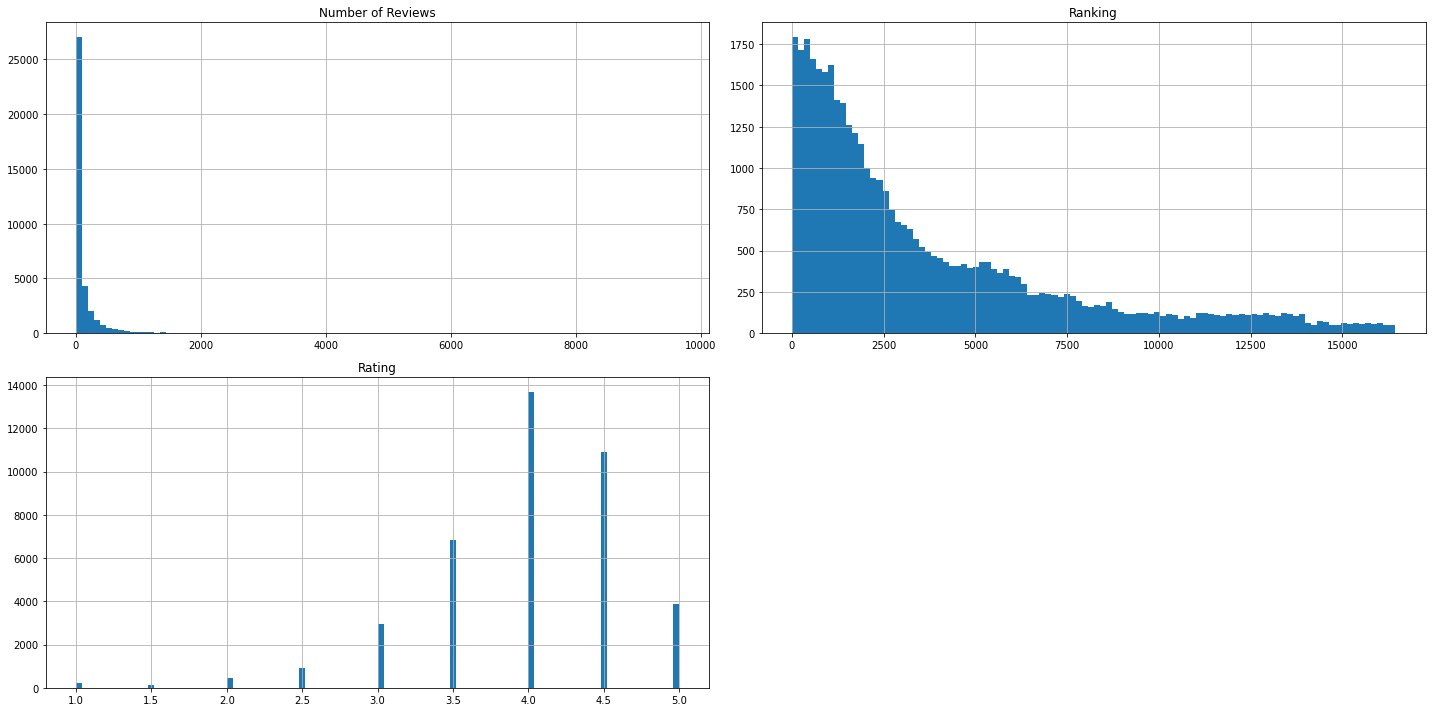

In [29]:
df[df.ForTrain][['Ranking', 'Rating', 'Number of Reviews','Price Range', 'Restaurant_id']].hist(figsize=(20, 10), bins=100);
plt.tight_layout()


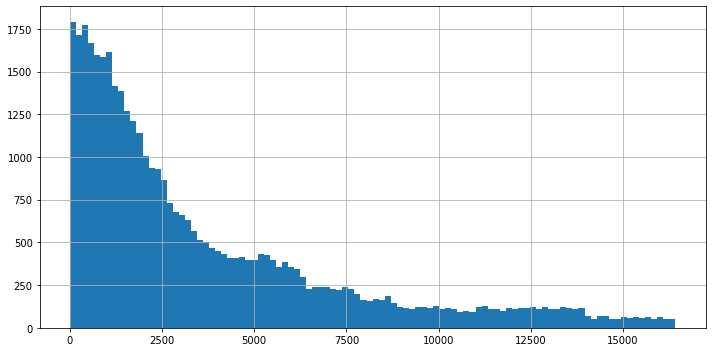

In [30]:
df[df.ForTrain]['Restaurant_id'].apply(lambda x: x.split('_')[1]).astype(int).hist(figsize=(10,5), bins=100);
plt.tight_layout()
# Restaurant_id Очень похож на Ranking

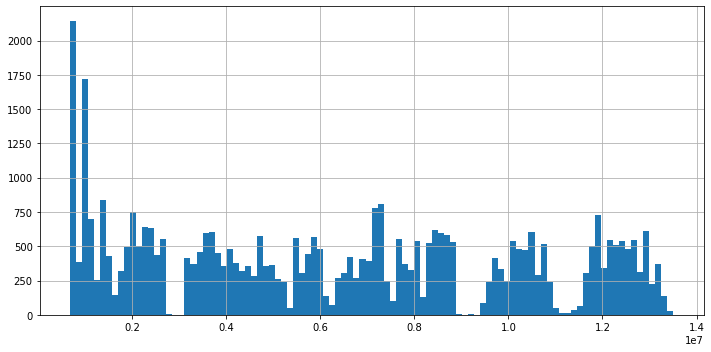

In [31]:
df[df.ForTrain]['ID_TA'].apply(lambda x: x.replace('d','')).astype(int).hist(figsize=(10, 5), bins=100);
plt.tight_layout()
# Видно Несколько групп - на ID - точно не похоже. 

In [32]:
df['ID_TA'] = df['ID_TA'].apply(lambda x: x[1:]) 

In [33]:
# Reviews - убираем NaN и "причесываем" текст отзывов 
df['Reviews_txt_NaN'] = df['Reviews'].apply(lambda x: x ==  '[[], []]')

# заменяем пустые значения на скобки (для удобных преобразований по одному шаблону)
df['Reviews'] = df['Reviews'].fillna('[[], []]')

# функция: чистим текст от ненужных символов - осталвяем только слова
df['Reviews'] = df['Reviews'].apply(lambda x: cleanup_string(x))

In [34]:
# Не будем кодировать названия городов - get_dummies справится 
# df["City"] = df["City"].astype('category')
# #df["City"] = df["City"].cat.codes
# encoder = LabelEncoder()
# df['City'] = encoder.fit_transform(df['City'])

In [35]:
# Перекодируем Price Range и удаляем NaN
cleanup_nums = {'Price Range':     {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}} # чаще всего встречается "$$ - $$$" == 2
# новый признак указывает: true - цена не указана, false - указана
df['Price Range NAN'] = df['Price Range'].isna()
df.replace(cleanup_nums, inplace=True)

In [36]:
# Получаем Cuisines Count, самую популярную кухню, среднее к-во кухонь в ресторане и устраняем NaN
# True - стиль кухни не указан
df['Cuisine Style NAN'] = df['Cuisine Style'].isna()
# Заменяем все пустые значения на строку NaN
df['Cuisine Style'] = df['Cuisine Style'].fillna('NaN')
# количество представленных кухонь в заведении
df['Cuisines Count'] = df.apply(cuisine_styles_count, axis=1)

# самая популярная кухня
most_popular_cusine = pd.Series(allCusines).value_counts().index[0]
# среднее количество представленных кухонь
average_cousines_count = np.round(df['Cuisines Count'].mean())

In [37]:
pd.Series(allCusines).value_counts()

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Fujian                     2
Burmese                    1
Latvian                    1
Xinjiang                   1
Salvadoran                 1
Length: 125, dtype: int64

In [38]:
# Number of Reviews
# рестораны без отзывов
df['Number of Reviews NAN'] = df['Number of Reviews'].isna()
# среднее количество отзывов
replace_val = df['Number of Reviews'].mean()
replace_val = np.round(replace_val)
# заменяем пустые значения на средние
df['Number of Reviews'] = df['Number of Reviews'].fillna(replace_val)

In [39]:
df.sample(5)

,Ranking,Rating,Number of Reviews,City,Price Range,Cuisine Style,Reviews,Restaurant_id,ID_TA,ForTrain,Reviews_txt_NaN,Price Range NAN,Cuisine Style NAN,Cuisines Count,Number of Reviews NAN
12583,618.0,4.0,316.0,Madrid,2,"['Steakhouse', 'Spanish', 'Grill']","[['Worth to try', 'De los mejores lechazos de ...",id_617,1118849,True,False,False,False,3,False
8476,373.0,4.0,202.0,Krakow,2,"['Polish', 'Bar', 'European', 'Pub', 'Central ...","[['Tasty beer', 'Great mugs'], ['09/05/2017', ...",id_372,3954480,True,False,False,False,5,False
37803,9489.0,5.0,124.0,London,2,NaN,"[['Fantastic Moroccan cafe'], ['09/02/2017']]",id_9480,12871676,True,False,True,True,1,True
10085,507.0,4.5,84.0,Athens,1,"['Italian', 'Mediterranean', 'Greek', 'Fast Fo...","[['Grate Food Cheap Price', 'Fast Food Pasta']...",id_506,8408963,True,False,False,False,6,False
17471,630.0,5.0,12.0,Athens,2,"['International', 'Greek']","[['No words!', 'Great bar'], ['05/23/2017', '0...",id_629,11746029,True,False,False,False,2,False


# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

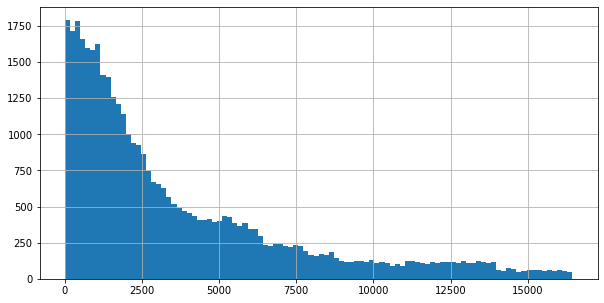

In [40]:
plt.rcParams['figure.figsize'] = (10,5)
df[df.ForTrain]['Ranking'].hist(bins=100);

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

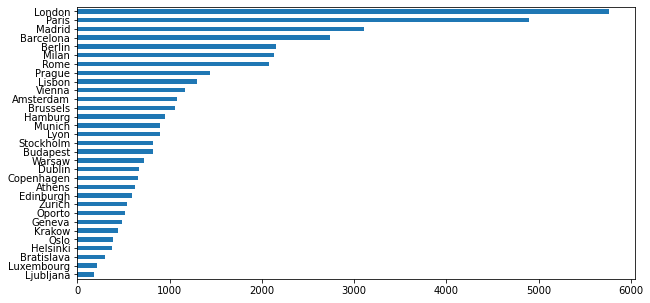

In [41]:
df[df.ForTrain]['City'].value_counts(ascending=True).plot(kind='barh');

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

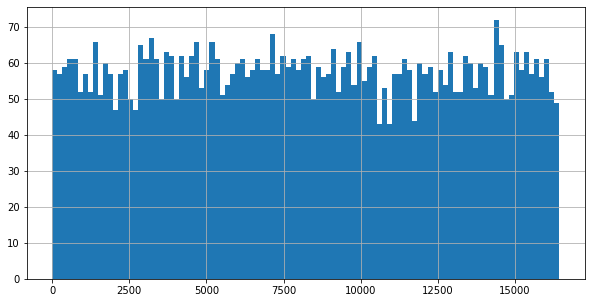

In [42]:
df[df.ForTrain]['Ranking'][df[df.ForTrain]['City'] =='London'].hist(bins=100);

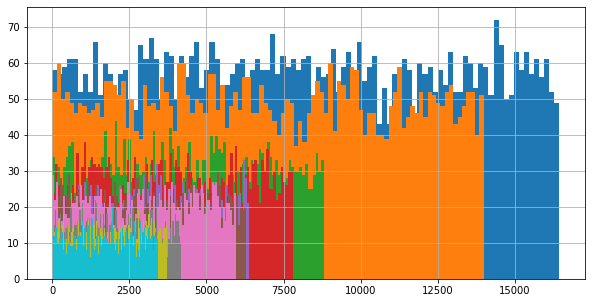

In [43]:
# посмотрим на топ 10 городов
for x in (df[df.ForTrain]['City'].value_counts())[0:10].index:
    df[df.ForTrain]['Ranking'][df[df.ForTrain]['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

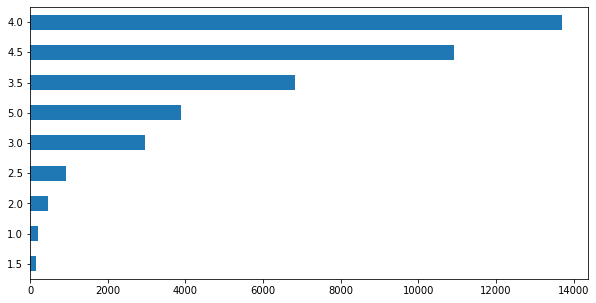

In [44]:
df[df.ForTrain]['Rating'].value_counts(ascending=True).plot(kind='barh');

### Посмотрим распределение целевой переменной относительно признака

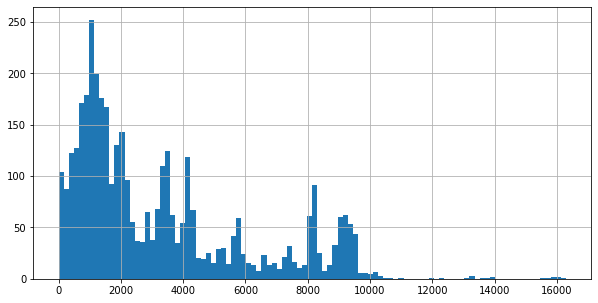

In [45]:
df[df.ForTrain]['Ranking'][df[df.ForTrain]['Rating'] == 5].hist(bins=100);

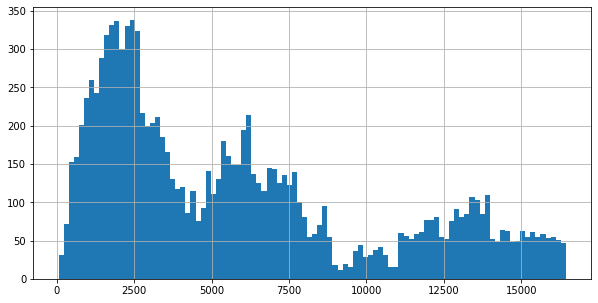

In [46]:
df[df.ForTrain]['Ranking'][df[df.ForTrain]['Rating'] < 4].hist(bins=100);

### Корреляция имеющихся признаков - практически единственным признаком, коррелирующим с Rating является Ranking. Он, в свою очередь, уже имеет слабую корреляцию практически со всеми признаками 

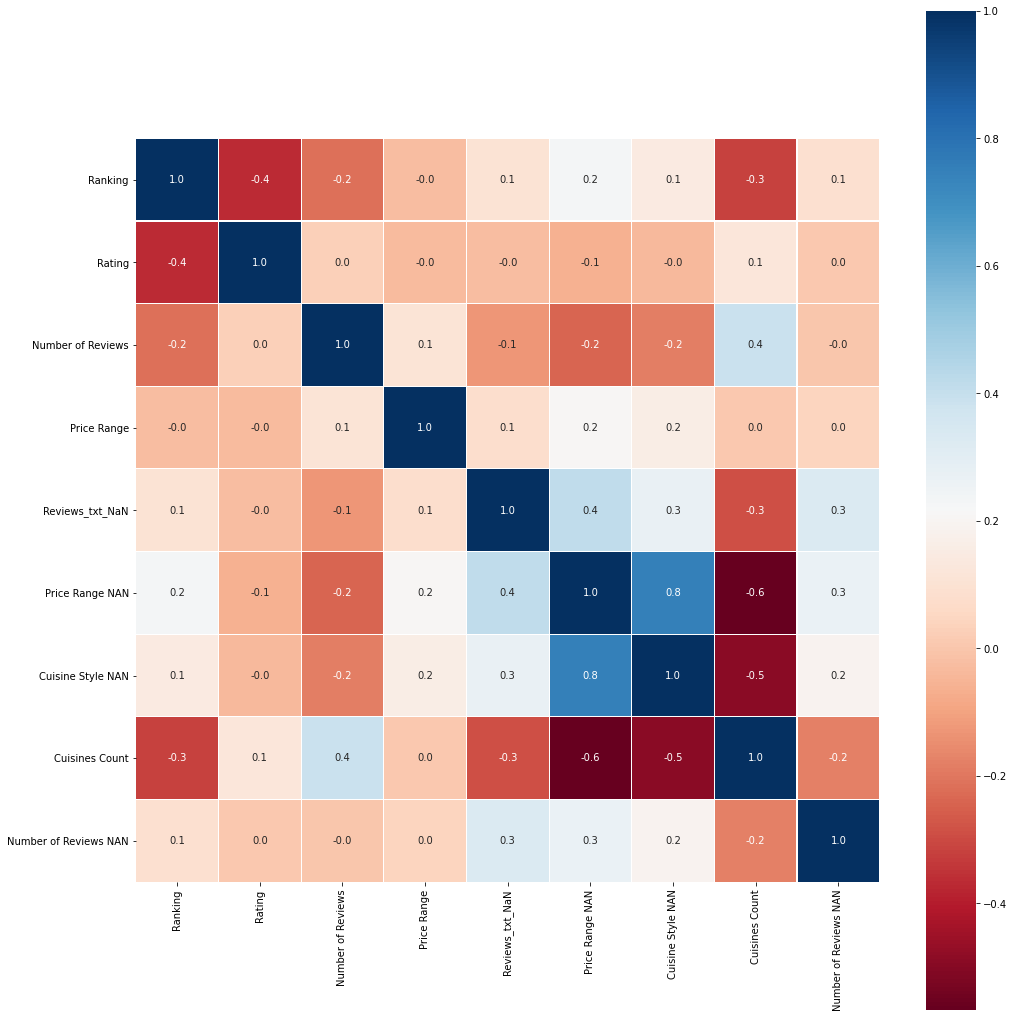

In [47]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(df[df.ForTrain].drop(['ForTrain'], axis=1).corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

**Поищем другие/дополнительные признаки, привлечем внешние данные **

In [48]:
# список с населением городов
population_city_dict = {}
# код страны
country_city_dict = {}
# Получаем словари популяции по городам, а так же ISO код страны по городу
population_city_dict, country_city_dict = get_city_population_and_country()

In [49]:
# Вычисляем страну для города в каждой строке
df['Country'] = df["City"].apply(lambda x: country_city_dict[x])

In [50]:
# Вычисляем к-во ресторанов для города в каждой строке
restorants_in_city = df.groupby('City')['Ranking'].count().to_dict()
df['Restaurants Count'] = df['City'].map(restorants_in_city)

In [51]:
# Вычисляем население (в тыс. чел) для города в каждой строке
df['Population'] = df["City"].map(population_city_dict)

In [52]:
# Вычисляем к-во ресторанов на 1000 чел для города в каждой строке
df['Restaurants for Population'] = df['Restaurants Count'] / (df['Population']*1000) #

In [53]:
# Вычисляем является ли город столицей в каждой строке
capital_city_dict = get_capital_city_dict()
df['isCapital'] = df["City"].map(capital_city_dict)

In [54]:
# Получаем относительную позицию ресторана среди всех ресторанов города
df['Weighed Rank'] = df.apply(lambda x: get_Weighed_Rank_RK(x), axis=1)

# коэффициент позиции ресторана
CityMinMax = df.groupby('City')['Ranking'].agg([min,max])
CityMinMax =CityMinMax.reset_index()
df['Weighed Rank min max'] = df.apply(lambda x: get_Weighed_Rank(x), axis=1)

In [55]:
# Флаги (1/0) isMostPopCusine - есть ли в ресторане самая популярная кухня; isMultyCusine - к-во кухонь в ресторане больше или столько же чем в среднем
df['isMostPopCusine'] = df['Cuisine Style'].apply(lambda x: 1 if most_popular_cusine in x else 0 )
df['isMultyCusine'] = df['Cuisines Count'].apply(lambda x: 1 if  x >= average_cousines_count else 0 )

In [56]:
# RevTimeDelta - время между review в днях
df['RevTimeDelta'] = df['Reviews'].apply(rev_time_delta)

In [57]:
# NewestReviewDate - время, прошедшее с момента последнего review до '13/02/2021'
df['NewestReviewDate'] = df['Reviews'].apply(lambda x: get_reviews(x)['reviews_dt'])
df['NewestReviewDate'] = df['NewestReviewDate'].apply(lambda x: sorted(x,reverse=True)[0] if len(x)!=0 else pd.NaT)
df['NewestReviewDate'] = df['NewestReviewDate'].fillna(dt.date(1970,1,1))
df['NewestReviewDate'] = df['NewestReviewDate'].apply(lambda x: (CURRENT_DATE.date()-x).total_seconds()//86400)

In [58]:
# сезон
df['NewestReviewSeason'] = df['Reviews'].apply(lambda x: get_reviews(x)['reviews_dt'])
df['NewestReviewSeason'] = df['NewestReviewSeason'].apply(lambda x: sorted(x,reverse=True)[0] if len(x)!=0 else pd.NaT)
df['NewestReviewSeason'] = df['NewestReviewSeason'].apply(lambda x: get_season(x))

In [59]:
#  'TxtReviewsCount' - к-во отзывов, не сильно улучшает результат, но пусть будут
df['TxtReviewsCount'] = df['Reviews'].apply(lambda x: len(get_reviews(x)['reviews_txt']))

In [60]:
# К-во позитивных слов в представленных отзывах
df['PositiveWords'] = df['Reviews'].apply(lambda x: count_positive_words_proportion(x))

In [61]:
# К-во негативных слов в представленных отзывах
df['NegativeWords'] = df['Reviews'].apply(lambda x: count_negative_words_proportion(x))

In [62]:
# Список уникальных позитивных слов в представленных отзывах
df['PositiveWordsList'] = df['Reviews'].apply(lambda x: list_positive_words(x))

In [63]:
cusines_in_city={}
cusines_count_in_city={}
for city_name, group in df.groupby('City'):

    cusines = group['Cuisine Style'].apply(get_cuisines)
   
    cusines_list = list(itertools.chain.from_iterable(cusines))
    # cusines_list = [x for x in cusines_list if x != 'Vegetarian Friendly'] # удаляем 'Vegetarian Friendly' - она "забивает" все результаты
    # счетчик количества городов
    cusines_in_city[city_name] = Counter(cusines_list)

for city_name in cusines_in_city.keys():
    cusines_count_in_city[city_name] = len(cusines_in_city[city_name])

# количество кухонь в городе
df['Cusines Count In City'] = df['City'].map(cusines_count_in_city)

In [64]:
# коэф: количество кухонь в ресторане / количество кухонь в городе
df['Weighed Cuisines Count'] = df['Cuisines Count'] / df['Cusines Count In City']  

In [65]:
# самая популярная кухня в городе
df['Most Common Cusine in City'] = df['City'].apply(lambda x: cusines_in_city[x].most_common(1)[0][0])

In [66]:
# подставляем в стили кухни ресторана вместо nan самую популярную кухню в городе
df['Cuisine Style'] = df.apply(lambda x: x['Cuisine Style'] if x['Cuisine Style NAN'] ==False else [x['Most Common Cusine in City']], axis=1)

In [67]:
# зависимость места ресторана в городе от населения
df['Weighed Rank by Population'] = df['Weighed Rank']  / df['Population'] 

In [68]:
# позитивных слов в 2х отзывах / количество отзывов
df['PositiveWords in Reviews'] = df['PositiveWords'] / df['Number of Reviews']

In [69]:
# Как часто в городе оставляют отзывы
df['NRP'] = df['Number of Reviews'] / df['Population']

In [70]:
# Ранг ресторана с учетом частоты отзывов в городе
df['WRR'] =  df['Weighed Rank']  *  df['NRP'] 

In [71]:
# ценник / ранг в городе
df['Relative Price Range'] = df['Price Range'] / df['Weighed Rank']

In [72]:
# Средняя цена в городе
price_in_city_dict = df.groupby('City')['Price Range'].mean().to_dict()
df['Price in City'] = df['City'].map(price_in_city_dict)

In [73]:
# Сокращаем список кухонь для анализа до N - основных, остальные Other - это почти всегда дает улучшение предсказания
N=30 #!!!

s = df['Cuisine Style'].apply(lambda x: get_cuisines(x))
slist =[]
for x in s:
    slist.extend(x)
topNcusines = set(pd.Series(slist).value_counts()[:N].index)  
df['Cuisine top N'] =df['Cuisine Style'].apply(lambda x: is_cuisine_top_N(x))

In [74]:
# Сетевой ID ресторана (похоже, что это ID франшизы, если повторяется более 1-го раза - isNetworkRestorant)
import warnings; warnings.simplefilter('ignore')
df['Restaurant_net_id'] = df['Restaurant_id'].apply(lambda x: x.split('_')[1])
NetworkRestorants = df[df['Restaurant_net_id'].isin(df['Restaurant_net_id'].value_counts()[df['Restaurant_net_id'].value_counts()>2].index)]
NetworkRestorants['isNetworkRestorant'] = True
df['isNetworkRestorant'] = NetworkRestorants['isNetworkRestorant']
df['isNetworkRestorant'] = df['isNetworkRestorant'].fillna(False)

In [75]:
# Помечаем, входит ли город в N-top городов, если ДА, то пишем его назавние, если НЕТ -Other
top_Cityes = df['City'].value_counts()[0:10].index.to_list()
df['TopCityes'] = df.City.apply(lambda x: x if x in top_Cityes else 'Other_City')

---
# Устранили NaN и сгенерили новые признаки(пока без dummies), посмотрим какие из них подходят 

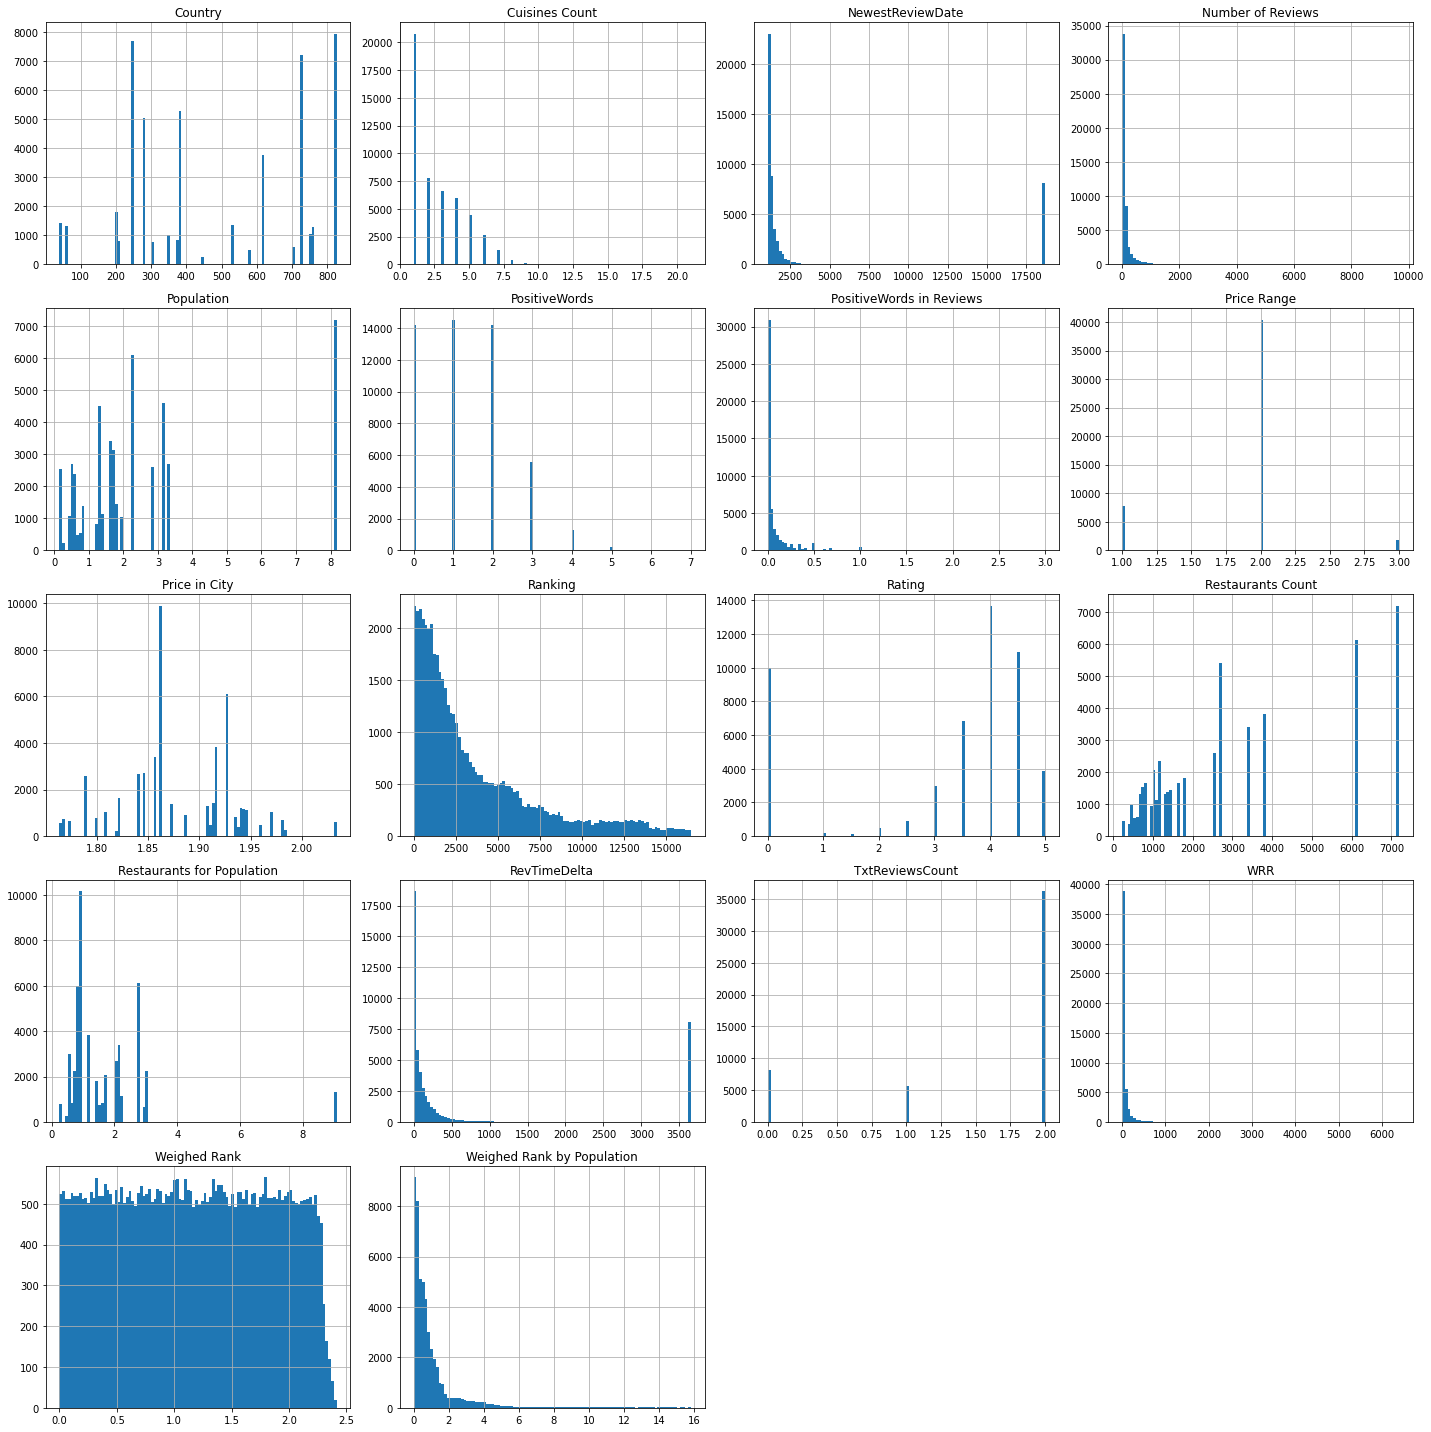

In [76]:
df[['Ranking', 'Rating', 'Number of Reviews', 'City', 'Price Range',
        'Restaurant_id',  'Country',
       'Restaurants Count', 'Population', 'Restaurants for Population',
       'Weighed Rank',  'Cuisines Count',
       'RevTimeDelta', 'NewestReviewDate',
       'TxtReviewsCount', 'Weighed Rank by Population', 'PositiveWords','PositiveWords in Reviews', 'WRR', 'Price in City', 'Restaurant_net_id']].hist(figsize=(20, 20), bins=100);
plt.tight_layout()

### Собираем dummies

In [77]:
df['Cuisine top N']

0                        [European, French, International]
1                                               [European]
2        [Vegetarian Friendly, Asian, Japanese, Sushi, ...
3                                         [Regionl Cusine]
4          [Vegetarian Friendly, Central European, German]
                               ...                        
49995                         [Vegetarian Friendly, Other]
49996                               [Asian, Indian, Other]
49997                                            [Italian]
49998                                            [Italian]
49999                                             [French]
Name: Cuisine top N, Length: 50000, dtype: object

In [78]:
# Собираем Dummies: city, price_range, country_range, Cuisine top N

dff = pd.get_dummies(df['Cuisine top N'].apply(pd.Series).stack()).sum(level=0)
df_mcc = pd.get_dummies(df['Most Common Cusine in City'], prefix = 'MCC')
df_city = pd.get_dummies(df['City'], prefix = 'City Range')
#df_city = pd.get_dummies(df['TopCityes'], prefix = 'City', dummy_na=True)
df_price_range = pd.get_dummies(df['Price Range'], prefix = 'Price Range') 
df_country_range = pd.get_dummies(df['Country'], prefix = 'Country Range',) 
#df_season_range = pd.get_dummies(df['NewestReviewSeason'], prefix = 'Season',)

df['PositiveWordsList'] = df['PositiveWordsList'].fillna('NAN')
df_positive_words_range = pd.get_dummies(df['PositiveWordsList'].apply(pd.Series).stack(), dummy_na=False).sum(level=0)


df1 = pd.concat([df,dff], axis=1)
df1 = pd.concat([df1,df_city], axis=1)
df1 = pd.concat([df1,df_price_range], axis=1)
df1 = pd.concat([df1,df_country_range], axis=1)
df1 = pd.concat([df1,df_mcc], axis=1)
df1 = pd.concat([df1,df_positive_words_range], axis=1)

#df1 = pd.concat([df1,df_season_range], axis=1)

#df1 = pd.concat([df1,df_restid_range], axis=1)

cols_cuisine_style = dff.columns
cols_city = df_city.columns
cols_price_range =  df_price_range.columns
cols_country_range =  df_country_range.columns
cols_mcc =  df_mcc.columns
cols_positive_words = df_positive_words_range.columns
#cols_season = df_season_range.columns
#cols_restid_range =  df_restid_range.columns

In [79]:
cols_price_range

Index(['Price Range_1', 'Price Range_2', 'Price Range_3'], dtype='object')

In [80]:
# Собираем признаки И Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
columns = [ 'isMultyCusine', 'Price Range NAN', 'Number of Reviews NAN', 'Number of Reviews', 'Restaurants Count', 'Cuisines Count', 'RevTimeDelta',        'NewestReviewDate', 'PositiveWords', 'NegativeWords', 'Weighed Rank', 'Ranking', 'Weighed Rank by Population',  'Cusines Count In City', 'WRR', 'ID_TA', 'Weighed Rank min max', 'Price in City',  'Cuisine Style NAN', 'isCapital', 'Population', 'Restaurants for Population',  ]

#columns = [ 'isMultyCusine', 'Price Range NAN', 'Cuisine Style NAN', 'Number of Reviews NAN', 'Number of Reviews', 'Restaurants Count', 'Cuisines Count', 'RevTimeDelta',        'NewestReviewDate', 'PositiveWords',  'Weighed Rank', 'Ranking', 'Weighed Rank by Population',  'Cusines Count In City', 'WRR', 'ID_TA', 'Weighed Rank min max', 'Price in City', 'Weighed Rank by Population',  ]

# добавляем dummy переменные
columns.extend(cols_price_range.tolist())
columns.extend(cols_cuisine_style.tolist())
columns.extend(cols_city.tolist())
columns.extend(cols_country_range.tolist())

columns.extend(cols_positive_words.tolist())

#Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
X = df1[df1.ForTrain][columns]

y = df1[df1.ForTrain]['Rating']

In [81]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [82]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 20% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Model 


In [83]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [84]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [85]:
# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [86]:
y_pred_old = y_pred.copy()
y_pred = round_of_rating(y_pred) 

In [87]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred),  metrics.mean_absolute_error(y_test, y_pred_old) )

MAE: 0.1579375 0.19234


In [88]:
#Вычисляем коэффициент детерминации:
R_2 = metrics.r2_score(y_test, y_pred)
print(R_2)

0.7763738280745223


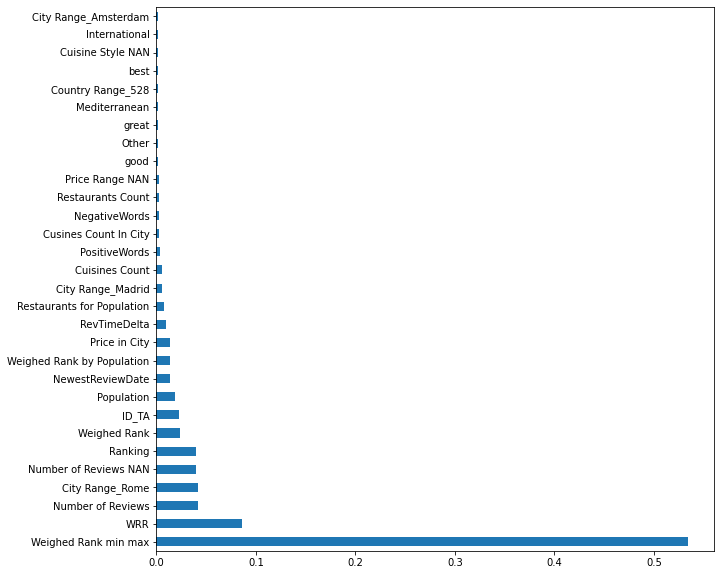

In [89]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh');

# Submission
Если все устраевает - готовим Submission на кагл

In [90]:
# Предсказываем рейтинги на датасете для предсказаний (ForTrain == False)
X_submission = df1[df1.ForTrain == False][columns]
y_pred_submission = round_of_rating(regr.predict(X_submission))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [91]:
# Формируем датасет с предсказаниями Restaurant_id -- Rating
submission_df = pd.DataFrame()
submission_df['Restaurant_id'] = df1[df1.ForTrain == False]['Restaurant_id']
submission_df['Rating'] = y_pred_submission
submission_df.head(15)

,Restaurant_id,Rating
40000,id_0,3.0
40001,id_1,4.5
40002,id_2,4.5
40003,id_3,4.5
40004,id_4,4.5
40005,id_5,4.5
40006,id_6,1.5
40007,id_7,3.0
40008,id_8,4.5
40009,id_9,4.5


-----------------
# Проверяем годность предсказаний  
Распределения достаточно похожи - ОК!

In [92]:
print('Тренировочный датасет')
df[df.ForTrain].Rating.value_counts()

Тренировочный датасет


4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

In [93]:
print('Предсказания масштабированные в 4 раза')
submission_df.Rating.value_counts()*4

Предсказания масштабированные в 4 раза


4.0    15052
4.5    11000
3.5     6676
3.0     2972
5.0     2900
2.5      728
2.0      380
1.0      188
1.5      104
Name: Rating, dtype: int64

In [94]:
# Сохраняем предсказания
submission_df.to_csv('submission.csv', index=False)